In [1]:
import pandas as pd

In [8]:
INPUT_DIR = 'C:/Users/baseb/OneDrive/ドキュメント/github/soturon/'

In [15]:
pd.read_csv(INPUT_DIR + 'data/kizawa_test.csv')

,日付,選手名,チーム内ID,項目名,値,内訳,備考,チーム別,学年,ポジション
0,2020/9/1,木澤 尚文,NaN,【朝】体重,85.9,NaN,NaN,NaN,NaN,投手
1,2020/9/1,木澤 尚文,NaN,【朝】疲労度,35.0,NaN,NaN,NaN,NaN,投手
2,2020/9/1,木澤 尚文,NaN,【朝】睡眠時間,7.0,0:00-7:00,NaN,NaN,NaN,投手
3,2020/9/1,木澤 尚文,NaN,【朝】睡眠の質,78.0,NaN,NaN,NaN,NaN,投手
4,2020/9/1,木澤 尚文,NaN,【朝】肩の状態,61.0,NaN,NaN,NaN,NaN,投手
...,...,...,...,...,...,...,...,...,...,...
265,2020/9/30,木澤 尚文,NaN,【朝】肩の状態,63.0,NaN,NaN,NaN,NaN,投手
266,2020/9/30,木澤 尚文,NaN,【朝】肘の状態,60.0,NaN,NaN,NaN,NaN,投手
267,2020/9/30,木澤 尚文,NaN,【朝】体幹の状態,60.0,NaN,NaN,NaN,NaN,投手
268,2020/9/30,木澤 尚文,NaN,【朝】下肢の状態,63.0,NaN,NaN,NaN,NaN,投手


In [19]:
def soturon(name):
    import math
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    import seaborn as sns
    import datetime as dt
    from scipy.stats import chi2
    import json
    import matplotlib.dates as mdates

    #標準化
    def scal(x,y):
        scaler = StandardScaler()
        scaler.fit(x.iloc[:,1:-1])
        return scaler.transform(y.iloc[:,1:-1])

    #相関行列の逆行列
    def cor(x):
        corr = np.corrcoef(x.T)
        return np.linalg.inv(corr)

    #マハラノビス汎距離
    def mahara(x,y):
        df_D2 = pd.DataFrame(columns = ['D2'])
        for i in range(len(x)):
            a = np.dot(x[i],y)
            d2 = np.dot(a,x[i].T)
            df_D2 = df_D2.append({'D2':d2},ignore_index=True) 
        return df_D2

    #名前入力
    # name = input('name?')

    #異常データの取得
    a = open(INPUT_DIR + 'code/.json/anomaly_day.json')
    js = json.load(a)
    an_days = js[name]

    #単位空間
    def unit_space(days):
        #trainデータ
        data_tr = pd.read_csv(INPUT_DIR + f'data/{name}_train.csv', encoding = 'utf-8', parse_dates = ['日付'])
        data_tr = data_tr[['日付','項目名','値']]
        df = pd.pivot_table(data_tr,index = '日付',columns = '項目名',values = '値')
        df = df.reset_index()
        df = df.interpolate(axis=0) #欠損値の線形補間
        df = df.rename(columns = {'日付':'DATE'})
        df = df.drop(['【朝】体重', '【朝】睡眠時間'], axis=1) #間違って取得した変数の削除
        x_clm = df.columns.unique()

        #異常の日を定義
        df['怪我状態'] = 0
        for i in range(len(days)):
            df.loc[df['DATE'] == days[i] , '怪我状態'] = 1


        #normalデータとanomalyデータを作成
        normal = df[df['怪我状態'] == 0].reset_index(drop = True)
        anomaly = df[df['怪我状態'] == 1].reset_index(drop = True)

        #testデータ
        data_ts = pd.read_csv(INPUT_DIR + f'data/{name}_test.csv',encoding = 'utf-8', parse_dates = ['日付'])
        data_ts = data_ts[['日付','項目名','値']]
        test = pd.pivot_table(data_ts,index = '日付',columns = '項目名',values = '値')
        test = test.reset_index()
        test = test.interpolate(axis=0) #線形補間
        test = test.rename(columns = {'日付':'DATE'})
        test = test.drop(['【朝】体重', '【朝】睡眠時間'], axis=1) #間違って取得した変数の削除
        test['怪我状態'] = 0

        #標準化
        scaled_nm = scal(normal,normal)
        scaled_an = scal(normal,anomaly) #異常データも正常データの平均と分散で標準化

        #相関行列の逆行列
        corr_inv = cor(scaled_nm) #正常データのΣ^―1

        #マハラノビス距離
        D2 = mahara(scaled_nm,corr_inv) / (len(x_clm)-1)
        D2['DATE'] = normal['DATE'] 

        return D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm

    #正常データに入っていた明らかな異常値をを単位空間から削除
    D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm = unit_space(an_days)
    a = D2.loc[D2['D2']>3,'DATE'] #項目数で割ったマハラノビス距離が3以上のものを削除
    an_days.extend(a.dt.strftime("%Y-%m-%d").to_list())

    #新しい単位空間を作成
    D2,test,scaled_nm,scaled_an,corr_inv,normal,anomaly,x_clm = unit_space(an_days)

    #L8直行表
    df_l8 = pd.DataFrame([[1,1,1,1,1,1,1],[1,1,1,2,2,2,2],[1,2,2,1,1,2,2],[1,2,2,2,2,1,1],[2,1,2,1,2,1,2],[2,1,2,2,1,2,1],[2,2,1,1,2,2,1],[2,2,1,2,1,1,2]])
    l8 = (df_l8==1).values

    #異常データのマハラノビス距離
    result = np.zeros(shape=(l8.shape[0], scaled_an.shape[0]))
    for x, l8_raw in enumerate(l8):
        for y, an_raw in enumerate(scaled_an):
            select_corr = corr_inv[l8_raw][:,l8_raw] #直交表で第一水準の項目のみでΣの逆行列
            select_raw = an_raw[l8_raw]
            result[x, y] = np.dot(np.dot(select_raw.reshape(1,-1), select_corr), select_raw) / sum(l8_raw)

    #SN比
    sn = np.zeros(l8.shape[0])
    for idx, raw in enumerate(result):
        a = 0
        for i in range(len(raw)):
            a += 1/np.square(raw[i])
        sn[idx] = -10 * math.log10(a/len(raw))
    sn_rate = pd.DataFrame(sn,columns = ['SN比'])

    #変数選択
    df_sn = pd.DataFrame(index = x_clm[1:],columns = ['SN比','残す'])
    for i in range(len(x_clm[1:])):
        df_sn.loc[df_sn.index == x_clm[1+i] , 'SN比'] = sum(sn[l8.T[i]])-sum(sn[l8.T[i] == False])
        df_sn.loc[df_sn.index == x_clm[1+i] , '残す'] = sum(sn[l8.T[i]])-sum(sn[l8.T[i] == False])>0
    select_v = df_sn.reset_index()

    #変数削除
    normal_d = normal.drop(columns=df_sn[df_sn['残す'] == False].index)
    anomaly_d = anomaly.drop(columns=df_sn[df_sn['残す'] == False].index)
    test_d = test.drop(columns=df_sn[df_sn['残す'] == False].index)

    #標準化
    scaled_normal_d = scal(normal_d,normal_d)
    scaled_anomaly_d = scal(normal_d,anomaly_d)

    #逆行列
    corr_inv_d = cor(scaled_normal_d)

    # 最終的な単位空間からのマハラノビス距離
    D2_normal_d = mahara(scaled_normal_d,corr_inv_d)
    D2_normal_d['DATE'] = normal['DATE']

    print('anomaly')
    D2_anomaly_d = mahara(scaled_anomaly_d,corr_inv_d)
    D2_anomaly_d['DATE'] = anomaly['DATE']

    # with pd.ExcelWriter(f"../../result/{name}_result.xlsx") as writer:
    #     sn_rate.to_excel(writer, sheet_name='sheet1')
    #     select_v.to_excel(writer, sheet_name='sheet2')
    #     D2_anomaly_d.to_excel(writer, sheet_name='sheet3')

    #ヒストグラム
    fig = plt.figure()
    ax1 = sns.distplot(
        D2_normal_d['D2'], label='D2_normal',color='#123456',
        kde=False,
        rug=False)
    ax2 = sns.distplot(
        D2_anomaly_d['D2'], label='D2_anomaly',color = 'red',
        kde=False,
        rug=False )
    plt.legend() 
    # fig.savefig(f"../../result/{name}_hist.png")

    #χ2検定の棄却域
    kai_0_1 = chi2.ppf(q = 0.999,df = df_sn['残す'].sum())
    kai_0_3 = chi2.ppf(q = 0.997,df = df_sn['残す'].sum())
    kai_1 = chi2.ppf(q = 0.99,df = df_sn['残す'].sum()) 
    kai_5 = chi2.ppf(q = 0.95,df = df_sn['残す'].sum()) 

    #trainデータのT²管理図
    #print('trainデータのT²管理図')
    D2_train_df = pd.concat([D2_normal_d,D2_anomaly_d])
    D2_train_df = D2_train_df.sort_values(['DATE'])
    fig = plt.figure()
    ax = sns.pointplot(x = 'DATE',y = 'D2',data = D2_train_df)
    ax.set_xticklabels(D2_train_df["DATE"].dt.strftime("%m-%d"))
    ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=7, tz=None))
    plt.xticks(rotation = 45)
    ax.axhline(y = kai_0_1, linewidth=2, color="red",alpha=0.3)
    ax.axhline(y = kai_0_3, linewidth=2, color="red",alpha=0.3)
    ax.axhline(y = kai_1, linewidth=2, color="red",alpha=0.3)
    # ax.axhline(y = kai_5, linewidth=2, color="red",alpha=0.3)
    ax.grid()
    # fig.savefig(f"../../result/{name}_train.png")

    #0.1%
    #print("0.1%有意")
    D2_train_df[D2_train_df['D2'] > kai_0_1]

    #0.3%
    #print("0.3%有意")
    D2_train_df[(D2_train_df['D2'] > kai_0_3) & (D2_train_df['D2'] < kai_0_1)]

    #1%
    #print("1%有意")
    D2_train_df[(D2_train_df['D2'] > kai_1) & (D2_train_df['D2'] < kai_0_3)]

    # #5%
    # print("5%有意")
    # display(D2_train_df[(D2_train_df['D2'] > kai_5) & (D2_train_df['D2'] < kai_1)])


    #testデータのT²管理図
    scaled_test = scal(normal_d,test_d)
    D2_test = mahara(scaled_test,corr_inv_d)
    D2_test['DATE'] = test['DATE']
    #print('testデータのT²管理図')
    fig = plt.figure()
    ax = sns.pointplot(x = 'DATE',y = 'D2',data = D2_test)
    ax.set_xticklabels(D2_test["DATE"].dt.strftime("%m-%d"))
    ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=None, interval=1, tz=None))
    plt.xticks(rotation = 90)
    ax.axhline(y = kai_0_1, linewidth=2, color="red",alpha=0.3)
    ax.axhline(y = kai_0_3, linewidth=2, color="red",alpha=0.3)
    ax.axhline(y = kai_1, linewidth=2, color="red",alpha=0.3)
    #ax.axhline(y = kai_5, linewidth=2, color="red",alpha=0.3)
    ax.grid()
    # fig.savefig(f"../../result/{name}_test.png")

    #0.1%
    # print("0.1%有意")
    D2_test[D2_test['D2'] > kai_0_1]

    #0.3%
    # print("0.3%有意")
    D2_test[(D2_test['D2'] > kai_0_3) & (D2_test['D2'] < kai_0_1)]

    #1%
    # print("1%有意")
    D2_test[(D2_test['D2'] > kai_1) & (D2_test['D2'] < kai_0_3)]

    # #5%
    # print("5%有意")
    # display(D2_test[(D2_test['D2'] > kai_5) & (D2_test['D2'] < kai_1)])



In [16]:
#異常データの取得
a = open(INPUT_DIR + 'code/.json/anomaly_day.json')
js = json.load(a)

In [17]:
js['kizawa']

['2020-06-14', '2020-06-15', '2020-07-15', '2020-07-19', '2020-07-24']

In [18]:
js['sekine']

['2020-07-05',
 '2020-07-31',
 '2020-08-04',
 '2020-08-11',
 '2020-08-12',
 '2020-08-17']

anomaly


C:\Users\baseb\anaconda3\envs\convenient\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


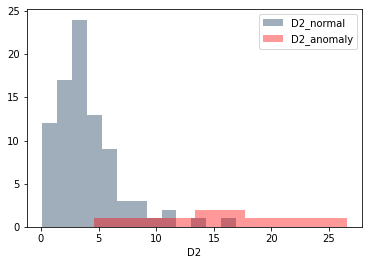

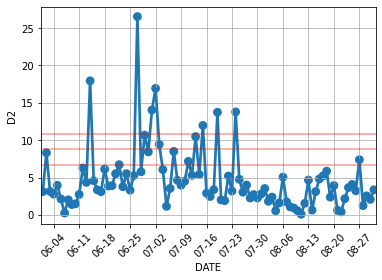

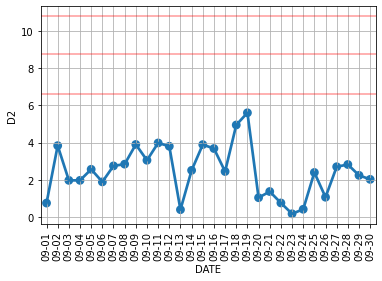

In [21]:
soturon('kizawa')

anomaly


C:\Users\baseb\anaconda3\envs\convenient\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


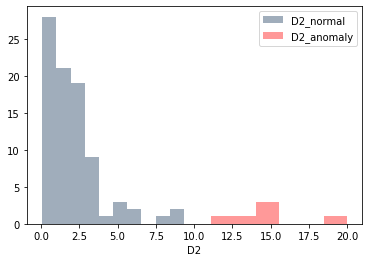

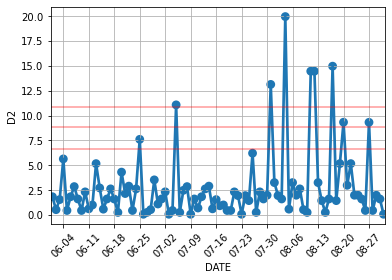

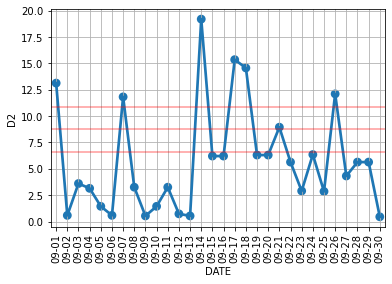

In [22]:
soturon('sekine')

In [23]:
js['sekine']

['2020-07-05',
 '2020-07-31',
 '2020-08-04',
 '2020-08-11',
 '2020-08-12',
 '2020-08-17']